# 3.1 MNIST

In [1]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [7]:
type(mnist)

sklearn.utils.Bunch

In [8]:
mnist.url

'https://www.openml.org/d/554'

In [9]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

(-0.5, 27.5, 27.5, -0.5)

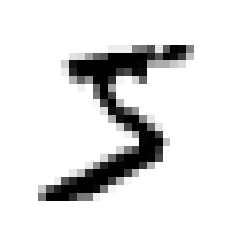

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(X = some_digit_image, cmap = 'binary')
plt.axis('off')

In [14]:
y[0] # the label of the image

'5'

In [16]:
type(y[0])

str

In [17]:
y = y.astype(np.uint8) # convert labels from strings to numbers 

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 Training a binary classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5

In [19]:
# True for all 5s, False for all other digits 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent (SGD) classifier. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X = X_train, y = y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 Performance measures

## 3.3.1 Measuring accuracy using cross-validation

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 

0.9669
0.91625
0.96785


In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(estimator = sgd_clf, X = X_train, y = y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [28]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(estimator = never_5_clf, X = X_train, y = y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## 3.3.2 Confusion matrix

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(estimator = sgd_clf, X = X_train, y = y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [33]:
len(y_train_pred)

60000

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = y_train_5, y_pred = y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [36]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 3.3.3 Precision and recall

- Precision = TP/(TP+FP)
- Recall = TP(TP+FN)

In [41]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_true = y_train_5, y_pred = y_train_pred), recall_score(y_true = y_train_5, y_pred = y_train_pred)

(0.8370879772350012, 0.6511713705958311)

It is often convenient to combine precision and recall into a single metric called the F score, in particular if you need a simple way to compare two classifiers. The F score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F score if both recall and precision are high

In [40]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

**Precision/Recall trade-off**

For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [42]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [44]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [45]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [46]:
y_scores = cross_val_predict(estimator = sgd_clf, 
                             X = X_train,
                             y = y_train_5, 
                             cv = 3,
                             method = 'decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

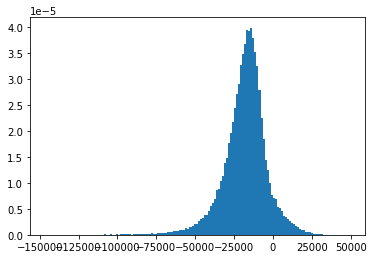

In [55]:
plt.hist(y_scores, bins = 150, density = True)
plt.show()

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_true = y_train_5, probas_pred = y_scores)

In [62]:
len(precisions), len(recalls), len(thresholds)

(59967, 59967, 59966)

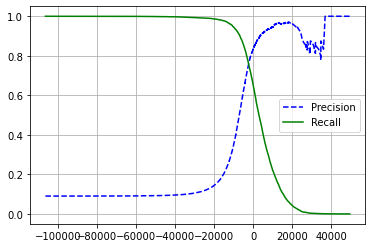

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.grid()
plt.show()

In [66]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [67]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [68]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

## 3.3.4 The ROC curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [70]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = y_train_5, y_score = y_scores)

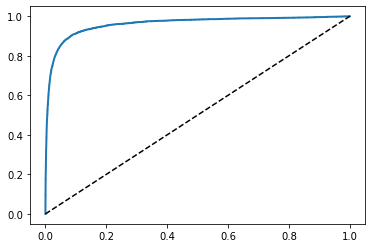

In [71]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [73]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true = y_train_5, y_score = y_scores)

0.9604938554008616

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works, the RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other, or both. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [75]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(estimator = forest_clf,
                                    X = X_train,
                                    y = y_train_5,
                                    cv = 3,
                                    method = 'predict_proba')

In [79]:
y_probas_forest.shape

(60000, 2)

In [80]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

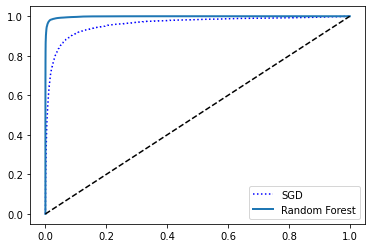

In [81]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')
plt.show()

In [82]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# 3.4 Multiclass classification

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers.

**One-versus-the-rest (OvR) strategy**: One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0- detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

**One-versus-one (OvO) strategy**: Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are N classes, you need to train N × (N – 1) / 2 classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.

In [84]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X = X_train, y = y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class:

In [85]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [87]:
np.argmax(some_digit_scores)

5

In [88]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [89]:
svm_clf.classes_[5]

5

If you want to force Scikit-Learn to use one-versus-one or one-versus-therest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier).

In [91]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(verbose = True))
ovr_clf.fit(X = X_train, y = y_train)
ovr_clf.predict([some_digit])

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([5], dtype=uint8)

In [92]:
len(ovr_clf.estimators_)

10

In [93]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. The decision_function() method now returns one value per class.

In [94]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [95]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy', verbose = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


array([0.87365, 0.85835, 0.8689 ])

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy', verbose = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.6min finished


array([0.8983, 0.891 , 0.9018])

# 3.5 Error analysis

In [98]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3, verbose = True)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.5min finished


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

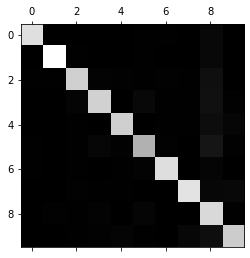

In [99]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [101]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

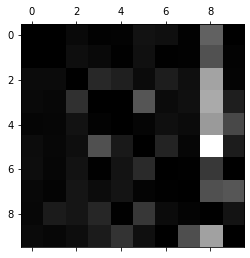

In [102]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

In [104]:
# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()

The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them

# 3.6 Multilabel classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a multilabel classification system

In [107]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. The next lines create a KNeighborsClassifier instance (which supports multilabel classification, though not all classifiers do), and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels

In [108]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

In [109]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, verbose = True)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 48.0min finished


0.976410265560605

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code

# 3.7 Multioutput classification

It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels

In [110]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [112]:
# knn_clf.fit(X_train_mod, y_train_mod)
# clean_digit = knn_clf.predict([X_test_mod[some_index]])
# plot_digit(clean_digit)